# Joensuu Tuiskavanluoto

**Tarkasteluväli:** _1986-1-1_ – _2024-12-31_

<img src="./attachments/13-3-5287105.avif" width="500"/>

Lähde: [Havaintojen lataus - Ilmatieteen Laitos](https://www.ilmatieteenlaitos.fi/havaintojen-lataus)

In [87]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

pl.Config.set_tbl_width_chars(140)
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(-1)

polars.config.Config

In [11]:
# Download dataset
source = Path("data/Liperi*")

weather_df = pl.read_csv(source, has_header=True, null_values=["-"])

In [12]:
# Shape and sample
print(weather_df.shape)
print(weather_df.sample(5))

(221993, 13)
┌───────────┬───────┬──────────┬───────┬───────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ Havaintoa ┆ Vuosi ┆ Kuukausi ┆ Päivä ┆ Aika [Pai ┆ Lämpötil ┆ Ylin läm ┆ Alin läm ┆ Keskituu ┆ Tuulen   ┆ Kovin    ┆ Tunnin   ┆ Suhteell │
│ sema      ┆ ---   ┆ ---      ┆ ---   ┆ kallinen  ┆ an keski ┆ pötila   ┆ pötila   ┆ len      ┆ suunnan  ┆ puuska   ┆ sademäär ┆ isen kos │
│ ---       ┆ i64   ┆ i64      ┆ i64   ┆ aika]     ┆ arvo     ┆ [°C]     ┆ [°C]     ┆ nopeus   ┆ keskiarv ┆ [m/s]    ┆ ä [mm]   ┆ teuden   │
│ str       ┆       ┆          ┆       ┆ ---       ┆ [°C]     ┆ ---      ┆ ---      ┆ [m/s]    ┆ o [°]    ┆ ---      ┆ ---      ┆ keskiar… │
│           ┆       ┆          ┆       ┆ str       ┆ ---      ┆ f64      ┆ f64      ┆ ---      ┆ ---      ┆ f64      ┆ str      ┆ ---      │
│           ┆       ┆          ┆       ┆           ┆ f64      ┆          ┆          ┆ f64      ┆ i64      ┆          ┆          ┆ i64      │


In [40]:
# Add "Päivämäärä" column (ISO 8601 date)
weather_df = (
    weather_df
    .with_columns(
        Päivämäärä=pl.date(pl.col("Vuosi"), pl.col("Kuukausi"), pl.col("Päivä"))
    )
    .sort("Päivämäärä")
)

In [46]:
# Min and max dates
min_date = weather_df.select("Päivämäärä").min().item()
max_date = weather_df.select("Päivämäärä").max().item()

print(f"Date range for observations: {min_date} – {max_date}")

Date range for observations: 1997-08-25 – 2023-07-12


In [51]:
# Print schema
for key, value in weather_df.schema.items():
    print(f"\"{key}\": {value}")

"Havaintoasema": String
"Vuosi": Int64
"Kuukausi": Int64
"Päivä": Int64
"Aika [Paikallinen aika]": String
"Lämpötilan keskiarvo [°C]": Float64
"Ylin lämpötila [°C]": Float64
"Alin lämpötila [°C]": Float64
"Keskituulen nopeus [m/s]": Float64
"Tuulen suunnan keskiarvo [°]": Int64
"Kovin puuska [m/s]": Float64
"Tunnin sademäärä [mm]": String
"Suhteellisen kosteuden keskiarvo [%]": Int64
"Päivämäärä": Date


## Visualizing mean temperature

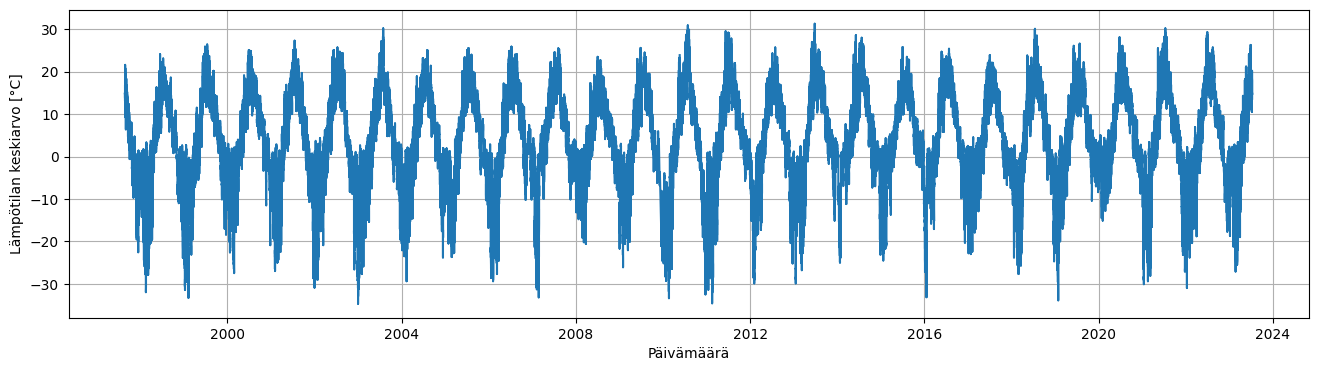

In [64]:
# plot
x = weather_df.select("Päivämäärä").to_series()
y = weather_df.select("Lämpötilan keskiarvo [°C]").to_series()

fig, ax = plt.subplots(figsize=(16, 4))
ax.grid(visible=True)
ax.plot(x,y)

ax.set_xlabel("Päivämäärä")
ax.set_ylabel("Lämpötilan keskiarvo [°C]")

plt.show()

## Visualising relationship between mean temperature and wind speed

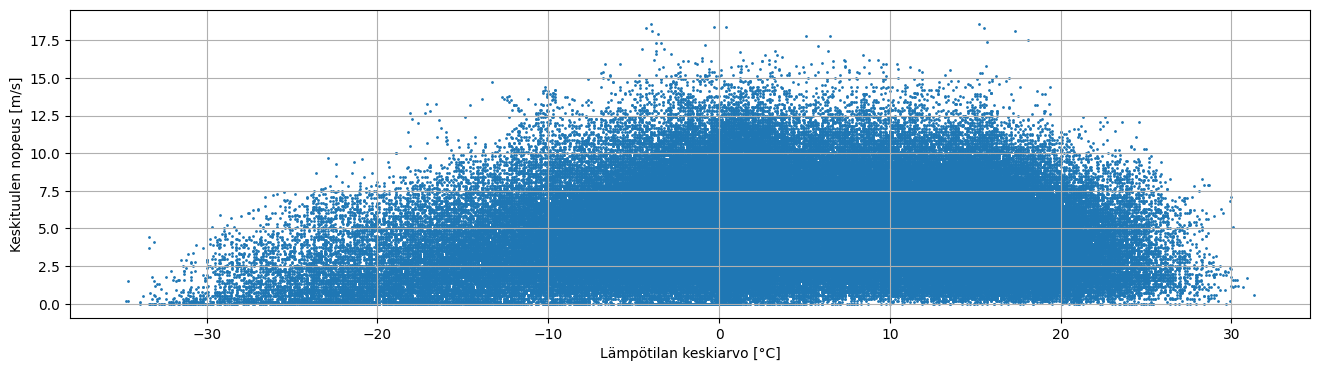

In [62]:
# Scatter plot
x = weather_df.select("Lämpötilan keskiarvo [°C]").to_series()
y = weather_df.select("Keskituulen nopeus [m/s]").to_series()

fig, ax = plt.subplots(figsize=(16, 4))
ax.grid(visible=True)
ax.scatter(x,y, s=1)

ax.set_xlabel("Lämpötilan keskiarvo [°C]")
ax.set_ylabel("Keskituulen nopeus [m/s]")

plt.show()

## TMAX and TMIN per period

Calculations are done similarly as defined in [USDA – National Water and Climate Center](https://www.nrcs.usda.gov/wps/portal/wcc/home/climateSupport/wetlandsClimateTables/exampleAndDefinitions).

In [92]:
daily_tmax_and_tmin_df = (
    weather_df
    .group_by_dynamic("Päivämäärä", every="1d")
    .agg(
        tmax=pl.col("Ylin lämpötila [°C]").max(),
        tmin=pl.col("Alin lämpötila [°C]").max()
    )
    .sort("Päivämäärä")
)

print(daily_tmax_and_tmin_df.shape)
print(daily_tmax_and_tmin_df.sample(10))

(9375, 3)
┌────────────┬──────┬──────┐
│ Päivämäärä ┆ tmax ┆ tmin │
│ ---        ┆ ---  ┆ ---  │
│ date       ┆ f64  ┆ f64  │
╞════════════╪══════╪══════╡
│ 2013-09-20 ┆ 15.3 ┆ 15.1 │
│ 2015-11-21 ┆ 0.3  ┆ 0.0  │
│ 2015-06-08 ┆ 13.3 ┆ 12.6 │
│ 1998-07-10 ┆ 22.7 ┆ 21.5 │
│ 2016-09-12 ┆ 15.3 ┆ 15.1 │
│ 2013-02-12 ┆ -0.6 ┆ -0.8 │
│ 2000-05-25 ┆ 14.5 ┆ 13.6 │
│ 2021-09-07 ┆ 13.9 ┆ 13.6 │
│ 2020-01-19 ┆ 2.6  ┆ 2.1  │
│ 2010-05-31 ┆ 15.3 ┆ 14.7 │
└────────────┴──────┴──────┘


In [101]:
yearly_snapshot_df = (
    daily_tmax_and_tmin_df
    .group_by_dynamic("Päivämäärä", every="1y")
    .agg(
        tmax=pl.col("tmax").mean(),
        tmin=pl.col("tmin").mean()
    )
    .sort("Päivämäärä")
)

bigger_snapshot_df = (
    yearly_snapshot_df
    .group_by_dynamic("Päivämäärä", every="9y", start_by="datapoint")
    .agg(
        tmax=pl.col("tmax").mean(),
        tmin=pl.col("tmin").mean()
    )
    .sort("Päivämäärä")
)

print(yearly_snapshot_df)
print(bigger_snapshot_df)

┌────────────┬──────────┬──────────┐
│ Päivämäärä ┆ tmax     ┆ tmin     │
│ ---        ┆ ---      ┆ ---      │
│ date       ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ 1997-01-01 ┆ 3.400775 ┆ 2.972868 │
│ 1998-01-01 ┆ 5.529041 ┆ 4.636438 │
│ 1999-01-01 ┆ 6.287293 ┆ 5.451381 │
│ 2000-01-01 ┆ 7.714566 ┆ 6.882073 │
│ 2001-01-01 ┆ 6.276438 ┆ 5.523014 │
│ 2002-01-01 ┆ 6.648767 ┆ 5.771507 │
│ 2003-01-01 ┆ 6.721978 ┆ 5.826374 │
│ 2004-01-01 ┆ 6.514208 ┆ 5.637158 │
│ 2005-01-01 ┆ 7.231044 ┆ 6.441484 │
│ 2006-01-01 ┆ 7.144932 ┆ 6.202192 │
│ 2007-01-01 ┆ 7.222192 ┆ 6.387123 │
│ 2008-01-01 ┆ 7.319126 ┆ 6.621858 │
│ 2009-01-01 ┆ 6.339091 ┆ 5.524848 │
│ 2010-01-01 ┆ 6.097376 ┆ 5.188338 │
│ 2011-01-01 ┆ 7.917582 ┆ 6.927473 │
│ 2012-01-01 ┆ 6.189167 ┆ 5.304722 │
│ 2013-01-01 ┆ 8.051781 ┆ 7.126849 │
│ 2014-01-01 ┆ 8.116986 ┆ 7.251781 │
│ 2015-01-01 ┆ 8.050411 ┆ 7.295616 │
│ 2016-01-01 ┆ 6.968579 ┆ 6.193716 │
│ 2017-01-01 ┆ 6.687397 ┆ 5.927945 │
│ 2018-01-01 ┆ 7.613973 ┆ 6.743836 │
│

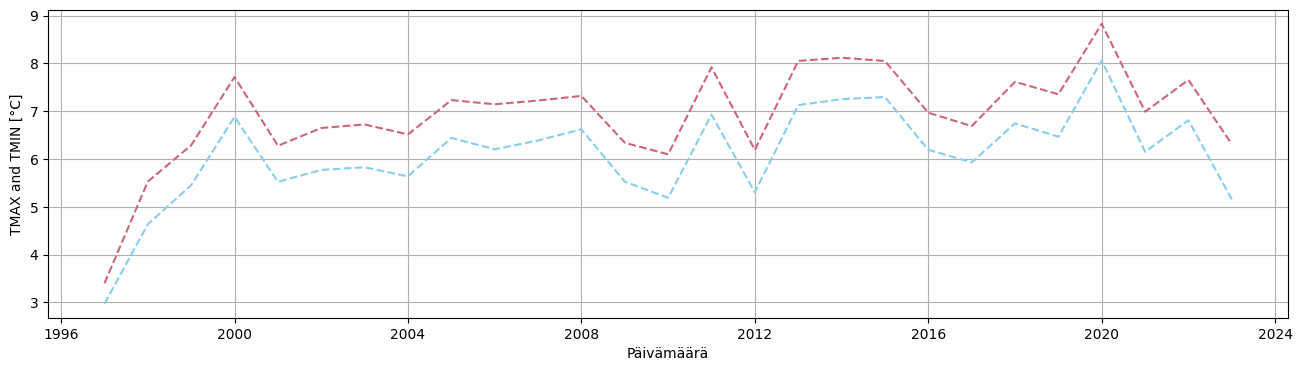

In [85]:
# plot
x = yearly_snapshot_df.select("Päivämäärä").to_series()
y1 = yearly_snapshot_df.select("tmax").to_series()
y2 = yearly_snapshot_df.select("tmin").to_series()

fig, ax = plt.subplots(figsize=(16, 4))
ax.grid(visible=True)
ax.plot(x, y1, "--", color="#CC6677")
ax.plot(x, y2, "--", color="#88CCEE")

ax.set_xlabel("Päivämäärä")
ax.set_ylabel("TMAX and TMIN [°C]")

plt.show()

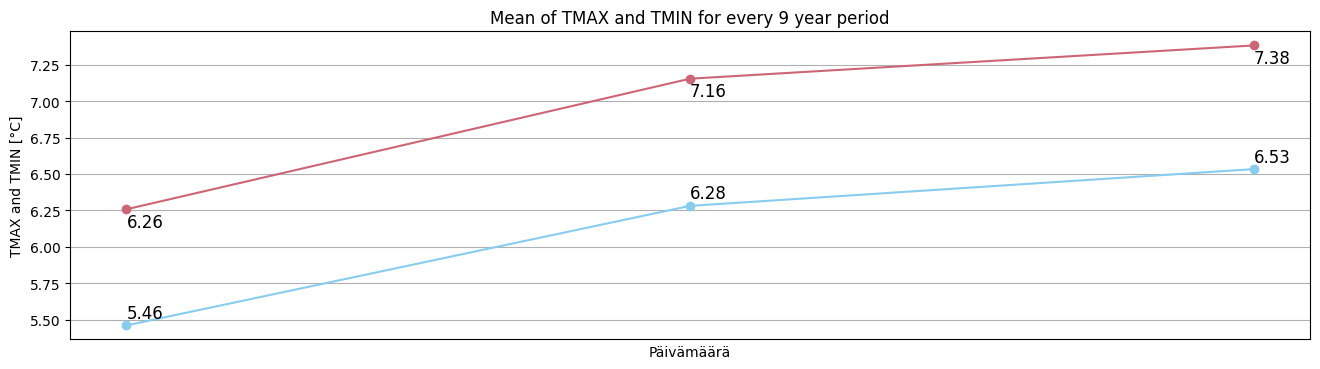

In [158]:
# plot
x = bigger_snapshot_df.select("Päivämäärä").to_series()
y1 = bigger_snapshot_df.select("tmax").to_series()
y2 = bigger_snapshot_df.select("tmin").to_series()

fig, ax = plt.subplots(figsize=(16, 4))
ax.grid(visible=True)
ax.plot(x, y1, "o-", color="#CC6677")
ax.plot(x, y2, "o-", color="#88CCEE")

ax.set_title("Mean of TMAX and TMIN for every 9 year period")
ax.set_xlabel("Päivämäärä")
ax.set_ylabel("TMAX and TMIN [°C]")

for i, item in enumerate(zip(y1, y2)):
    ax.text(x[i], y1[i] - .12, f"{item[0]:0.2f}", fontsize=12)
    ax.text(x[i], y2[i] + .05, f"{item[1]:0.2f}", fontsize=12)

ax.set_xticks([])

plt.show()

## The components of a Matplotlib Figure

Here are the components of a Matplotlib Figure.

<img src="./attachments/anatomy.webp" width="700"/>

Source: [Matplotlib - Parts of a Figure](https://matplotlib.org/stable/users/explain/quick_start.html#parts-of-a-figure)